<a href="https://colab.research.google.com/github/frogbysachs/LASA-Data-Science/blob/Unit-5/FrogSachU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

#Preamble
For this project I want to look at the habits and lifestyles of a bunch of students and see what kind of information I can extrapolate from it.

I found a data set on Kaggle that looks at the lifestyles of 2000 Indian students, with self-reported data for each one.

In [2]:
#import data from Kaggle on 2000 students' lifestyles
url = "https://raw.githubusercontent.com/frogbysachs/LASA-Data-Science/refs/heads/Unit-5/student_lifestyle_dataset.csv"
rawdata = pd.read_csv(url)

#I wanna see what it looks like!
rawdata

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High
...,...,...,...,...,...,...,...,...
1995,1996,6.5,0.2,7.4,2.1,7.8,3.32,Moderate
1996,1997,6.3,2.8,8.8,1.5,4.6,2.65,Moderate
1997,1998,6.2,0.0,6.2,0.8,10.8,3.14,Moderate
1998,1999,8.1,0.7,7.6,3.5,4.1,3.04,High


<Axes: xlabel='Study_Hours_Per_Day', ylabel='GPA'>

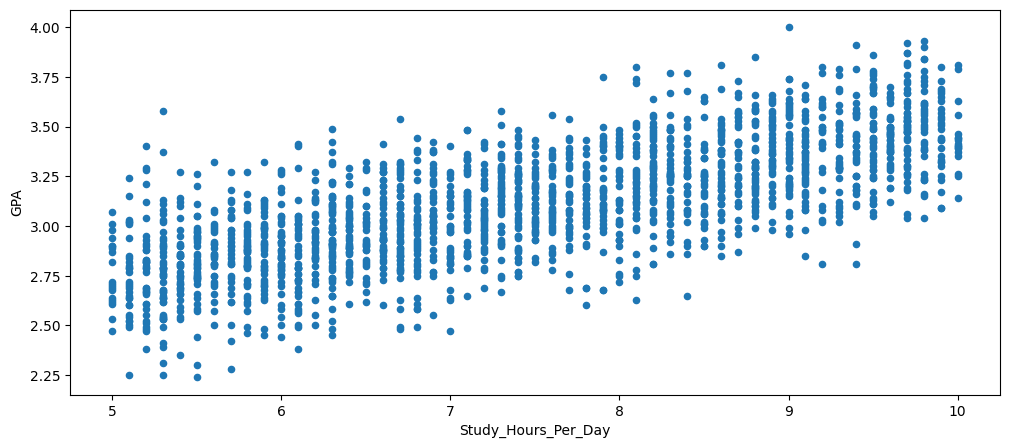

In [3]:
#I'm going to start by plotting variables that I think will have a cool trend to look at:
rawdata.plot(x="Study_Hours_Per_Day", y="GPA", figsize=(12, 5), kind="scatter")

#Linear modeling
Next I want to create a linear model for this data, and I'm starting with a simple Deterministic model with no translations. After that, I'll graph a posterior with my model's best fit line, and we'll see how it looks.

In [4]:
#ls stands for linear student
with pm.Model() as model_ls:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * rawdata.Study_Hours_Per_Day)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=rawdata.GPA)

    #inference data object
    idata_ls = pm.sample()

Output()

Output()

Text(0, 0.5, 'GPA')

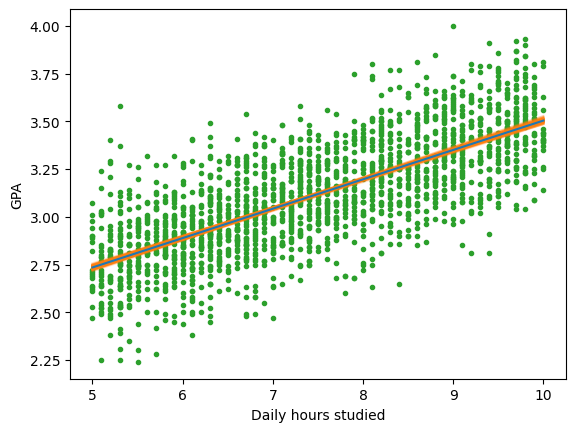

In [5]:
#grabs 100 posterior samples
posterior = az.extract(idata_ls, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(rawdata.Study_Hours_Per_Day.min(), rawdata.Study_Hours_Per_Day.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(rawdata.Study_Hours_Per_Day, rawdata.GPA, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Daily hours studied")
ax.set_ylabel("GPA")

Output()

<Axes: xlabel='y_pred'>

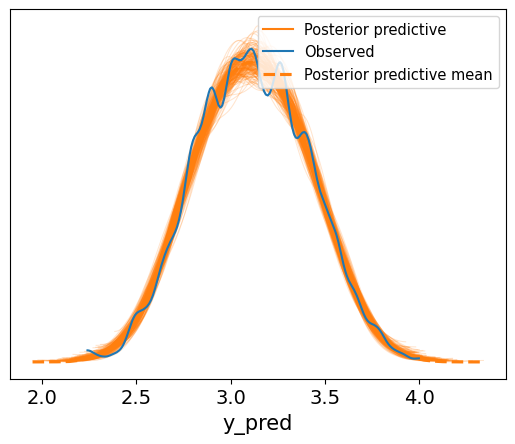

In [6]:
#Now time for a posterior predictive check
pm.sample_posterior_predictive(idata_ls, model=model_ls,  extend_inferencedata=True)
az.plot_ppc(idata_ls, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'GPA')

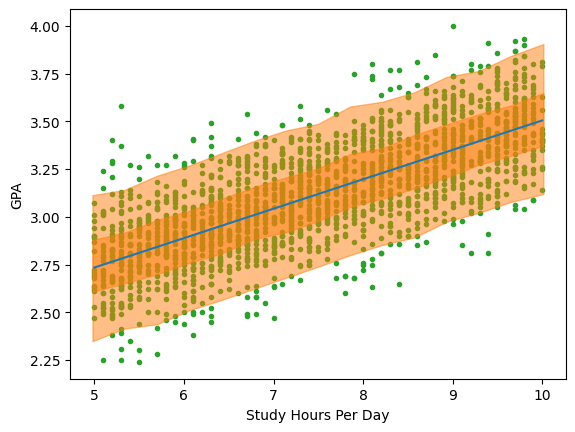

In [7]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_ls.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
samplehrs = np.random.normal(rawdata.Study_Hours_Per_Day.values, 0.01)
idx = np.argsort(samplehrs)
x = np.linspace(samplehrs.min(), samplehrs.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_ls.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(samplehrs[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(rawdata.Study_Hours_Per_Day, rawdata.GPA, "C2.", zorder=-3)
ax.plot(rawdata.Study_Hours_Per_Day[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Study Hours Per Day")
ax.set_ylabel("GPA")

Both my posterior predictive check and posterior predictive distribution were pretty solid.

Despite multiple small spikes in the observed data on the PPC graph, my posterior predictive graphs all matched the general shape quite well, and the posterior predictive distribution seems to encapsulate almost all my data with a pretty reasonable-looking graph.

I honestly do feel pretty good about representing this data with a linear trend, but I feel like this was almost too easy and kind of want to try some other type of GLM- maybe something logarithmic? I'm thinking that there should be some kind of diminishing returns effect, which is why I'm trying this one.

In [10]:
#sqrs stands for squared student
with pm.Model() as model_sqrs:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μsqr = pm.Deterministic("μ", α + β * pm.math.log(rawdata.Study_Hours_Per_Day))

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred2 = pm.Normal("y_pred2", mu=μsqr, sigma=σ, observed=rawdata.GPA)

    #inference data object
    idata_sqrs = pm.sample()

Output()

Output()

Output()

Text(0, 0.5, 'GPA')

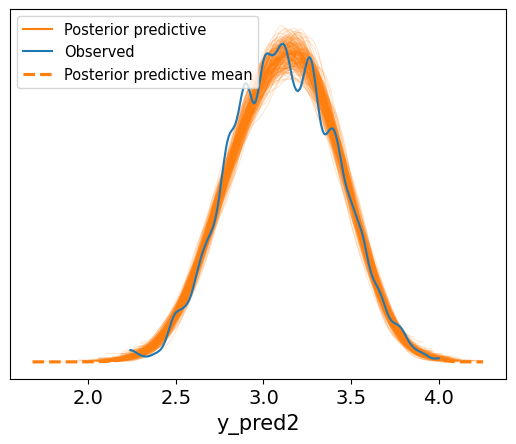

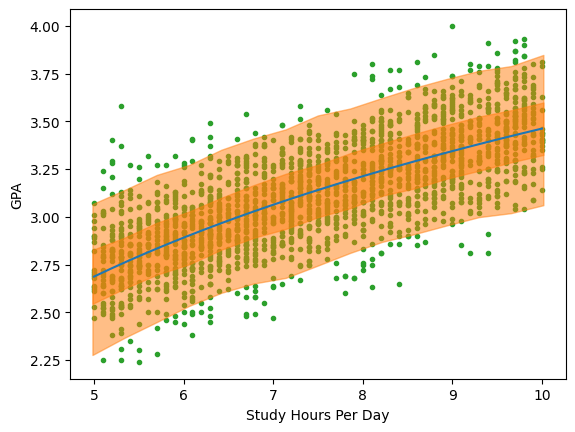

In [11]:
#Now time for a posterior predictive check
pm.sample_posterior_predictive(idata_sqrs, model=model_sqrs,  extend_inferencedata=True)
az.plot_ppc(idata_sqrs, num_pp_samples=200, colors=["C1", "C0", "C1"])



#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line1 = idata_sqrs.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
samplehrs = np.random.normal(rawdata.Study_Hours_Per_Day.values, 0.01)
idx = np.argsort(samplehrs)
x = np.linspace(samplehrs.min(), samplehrs.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q1 = idata_sqrs.posterior_predictive["y_pred2"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(samplehrs[idx], y_pred_q1[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(rawdata.Study_Hours_Per_Day, rawdata.GPA, "C2.", zorder=-3)
ax.plot(rawdata.Study_Hours_Per_Day[idx], mean_line1[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Study Hours Per Day")
ax.set_ylabel("GPA")

#Analysis
I wound up with two different ways to look at the same data- one as a purely linear regression, and one as a logarithmic curve. There's such little difference between the two PPC graphs, and between the two PP distribution graphs, that I really just have to decide which one is a better fit.

I'm honestly more inclined to believe that there's not a linear relationship between hours studied and GPA because at a certain point, there's a maximum GPA that's even possible, and studying more hours than that will necessarily have no positive effect on GPA. Furthermore, I think of time studying as a "diminishing returns" effect- that is to say that there's a bigger difference between studying for 0 and 2 hours than there is between studying for 8 and 10 hours. So I think that the curve that makes the most sense here is probably the logarithmic model.

(Final note: if you look closely, the PPC graph for the logarithmic model is actually a little bit worse, but not significantly enough that it's making me want to overhaul my conclusion.)